# Решение спитцеровского уравнения теплопроводности плазмы

## Неявная разностная схема с нелинейностью на нижнем слое

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^n_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^n_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right] + f^n_m
$$

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.pyplot import axes
from celluloid import Camera
import utils

In [40]:
def u_init(x, To):
    u = np.zeros(x.size)
    for i in range(len(x)):
        if x[i] <= 1:
            u[i] = To
    return u

### Метод прогонки

In [41]:
A = np.array([[11,4,0,0],
              [3,10,4,0],
              [0,1,7,5],
              [0,0,3,4]])
a = np.diag(A, -1)
b = np.diag(A)
c = np.diag(A, 1)
d = np.array([3, 4, 5, 6.])
print(np.linalg.solve(A, d))
print(utils.thomas_solver(a, -b, c, d))

[-0.02367942  0.8151184  -1.02003643  2.26502732]
[-0.02367942  0.8151184  -1.02003643  2.26502732]


#### Применение метода

In [42]:
import importlib
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\aleks\\Documents\\Projects\\Comp math\\utils.py'>

In [43]:
# Начальные значения
a = 0
b = 4
t_0 = 0
T = 0.005
To = 2

In [44]:
# Число узлов
N = 20000
M = 2000

# Размер шага сетки
h = (b - a) / M
tau = (T - t_0) / N
print(f'{h=}, {tau=: .8f}')

print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h=0.002, tau= 0.00000025
sigma =  0.0312


In [45]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [46]:
u1 = np.zeros((N + 1, M), dtype=np.double)
u1[0, :] = u_init(x, 2)

u2 = np.zeros((N + 1, M), dtype=np.double)
u2[0, :] = u_init(x, 2)

In [47]:
for n in tqdm(range(N)):
    a_e, b_e, c_e, d_e = utils.make_diagonals(u1, u2, n, tau, h, M, mode='electrons')
    u_sol = utils.thomas_solver(a_e, b_e, c_e, d_e)
    u1[n + 1, :] = u_sol
    a_i, b_i, c_i, d_i = utils.make_diagonals(u1, u2, n, tau, h, M, mode='ion')
    u2[n + 1, :] = utils.thomas_solver(a_i, b_i, c_i, d_i)

  0%|          | 0/20000 [00:00<?, ?it/s]

#### Визуализация

MovieWriter imagemagick unavailable; using Pillow instead.


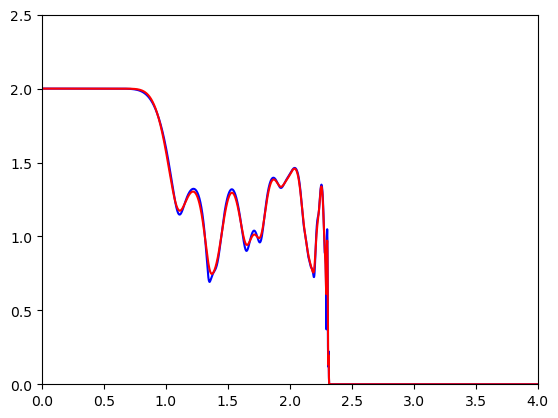

In [49]:
fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(a, b), ylim=(0, 2.5))

for i in range(0, N, 30):
    ax.plot(x, u1[i, :], color="blue")
    ax.plot(x, u2[i, :], color="red")
    camera.snap()
animation = camera.animate()
animation.save('oh_my.gif', writer = 'imagemagick')

In [11]:
from IPython.display import Image
Image(url='oh_my.gif')

### Метод потоковой прогонки